In [0]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/jdariasl/DiplomadoEPM_2019/master/Modulo3/init.py
from init import init; init(force_download=False)

In [1]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

'2.1.0'

In [2]:
import tensorflow as tf
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle, bz2
from local.lib import mlutils
%matplotlib inline

## Observe AlexNet filters for the first two convolutional layers

Pretrained Network: https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/

Paper: [ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)

Source images: [Large Scale Visual Recognition Challenge 2012](http://www.image-net.org/challenges/LSVRC/2012/) [ImageNet](http://www.image-net.org)

Local file with weights from first two layers only



In [3]:
!ls -lash local/data/alexnet_conv1_conv2.pklz

1,4M -rw-r--r-- 1 rlx rlx 1,4M feb 28 17:55 local/data/alexnet_conv1_conv2.pklz


In [4]:
alex_c12 = pickle.load(bz2.BZ2File("local/data/alexnet_conv1_conv2.pklz", "r"), encoding='latin1')
for k,(w,b) in alex_c12.items():
    print (k, b.shape, w.shape)

conv2 (256,) (5, 5, 48, 256)
conv1 (96,) (11, 11, 3, 96)


we use for the moment only the first layer

(11, 11, 3, 96)


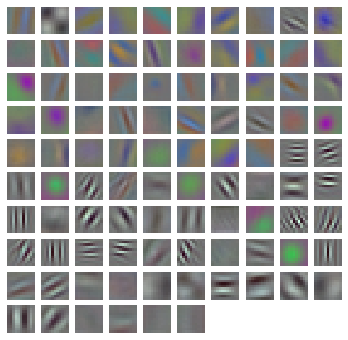

In [5]:
alex_w1 = alex_c12["conv1"][0]
print (alex_w1.shape)
mlutils.display_imgs(alex_w1)


### We will use them as starting point of our network

In [6]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5

File ‘mini_cifar.h5’ already there; not retrieving.



In [7]:
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]

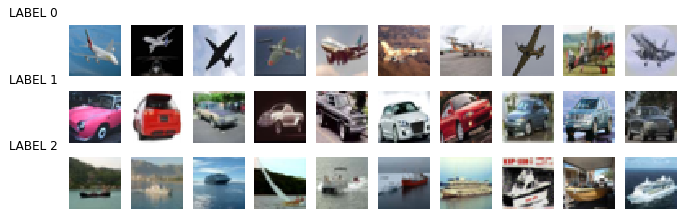

In [8]:
mlutils.show_labeled_image_mosaic(x_cifar, y_cifar)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print (x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print ("\ndistribution of train classes")
print (pd.Series(y_train).value_counts())
print ("\ndistribution of test classes")
print (pd.Series(y_test).value_counts())

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)

distribution of train classes
2    763
1    754
0    736
dtype: int64

distribution of test classes
0    269
2    262
1    220
dtype: int64


In [10]:
def get_conv_model_C(num_classes, img_size=32, compile=True):
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(96,(11,11), activation="relu")(inputs)
    layers = tf.keras.layers.MaxPool2D((2,2))(layers)
    layers = tf.keras.layers.Conv2D(60,(11,11), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.4)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [11]:
def train(model, batch_size, epochs, model_name=""):
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir="logs/"+model_name+"_"+"{}".format(time()))
    model.reset_states()
    model.fit(x_train, y_train, epochs=epochs, callbacks=[tensorboard],
              batch_size=batch_size,
              validation_data=(x_test, y_test))
    metrics = model.evaluate(x_test, y_test)
    return {k:v for k,v in zip (model.metrics_names, metrics)}



In [12]:
num_classes = len(np.unique(y_cifar))
model = get_conv_model_C(num_classes)
model.summary()

using 3 classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 22, 22, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 11, 11, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 1, 60)          697020    
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 16)      

## Training from scratch to measure benefit from transfer learning

In [13]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 2253 samples, validate on 751 samples
Epoch 1/15
2253/2253 [==============================] - 7s 3ms/sample - loss: 1.0940 - accuracy: 0.3782 - val_loss: 1.0918 - val_accuracy: 0.3702
Epoch 2/15
2253/2253 [==============================] - 10s 4ms/sample - loss: 1.0417 - accuracy: 0.4598 - val_loss: 0.9975 - val_accuracy: 0.5140
Epoch 3/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 1.0140 - accuracy: 0.4984 - val_loss: 0.9769 - val_accuracy: 0.5846
Epoch 4/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.9701 - accuracy: 0.5269 - val_loss: 0.9214 - val_accuracy: 0.6045
Epoch 5/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.9477 - accuracy: 0.5446 - val_loss: 0.8912 - val_accuracy: 0.5992
Epoch 6/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.9276 - accuracy: 0.5490 - val_loss: 0.9056 - val_accuracy: 0.6005
Epoch 7/15
2253/2253 [==============================] - 9s 4ms/sample - loss

{'loss': 0.8861232938049002, 'accuracy': 0.5952064}

## Transfer learning!!!

- we simply set the weights of the layers we are interested into


In [14]:
model = get_conv_model_C(num_classes)
w = model.get_weights()
for i in w:
    print (i.shape)

using 3 classes
(11, 11, 3, 96)
(96,)
(11, 11, 96, 60)
(60,)
(60, 16)
(16,)
(16, 3)
(3,)


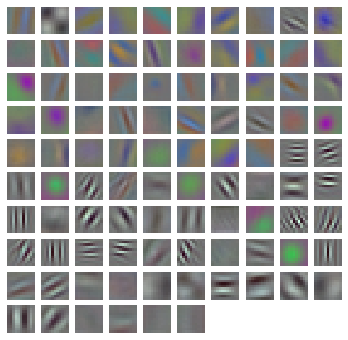

In [15]:
w[0] = alex_w1
mlutils.display_imgs(w[0])

In [16]:
model.set_weights(w)

In [17]:
train(model, batch_size=16, epochs=15, model_name="alexnet_fintuned")

Train on 2253 samples, validate on 751 samples
Epoch 1/15
2253/2253 [==============================] - 7s 3ms/sample - loss: 1.0413 - accuracy: 0.4763 - val_loss: 0.8933 - val_accuracy: 0.5992
Epoch 2/15
2253/2253 [==============================] - 11s 5ms/sample - loss: 0.9069 - accuracy: 0.5535 - val_loss: 0.8374 - val_accuracy: 0.6618
Epoch 3/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.8319 - accuracy: 0.6059 - val_loss: 0.7097 - val_accuracy: 0.6964
Epoch 4/15
2253/2253 [==============================] - 8s 4ms/sample - loss: 0.7883 - accuracy: 0.6356 - val_loss: 0.7328 - val_accuracy: 0.6884
Epoch 5/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.7305 - accuracy: 0.6755 - val_loss: 0.7625 - val_accuracy: 0.6818
Epoch 6/15
2253/2253 [==============================] - 9s 4ms/sample - loss: 0.7257 - accuracy: 0.6782 - val_loss: 0.7588 - val_accuracy: 0.6871
Epoch 7/15
2253/2253 [==============================] - 10s 4ms/sample - los

{'loss': 0.703013724993453, 'accuracy': 0.7310253}

Normalized confusion matrix
[[0.65799257 0.07063197 0.27137546]
 [0.06818182 0.76818182 0.16363636]
 [0.17557252 0.04961832 0.77480916]]


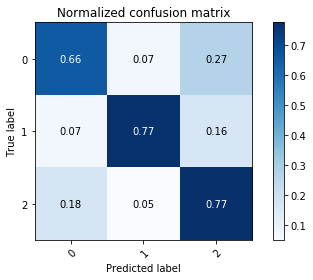

In [18]:
test_preds = model.predict(x_test).argmax(axis=1)
mlutils.plot_confusion_matrix(y_test, test_preds, classes=np.r_[0,1,2], normalize=True)

observa que los filtros de primer nivel cambiaron, pero muy poco

In [19]:
w0 = model.get_weights()[0]
np.mean(np.abs(w0-alex_w1))

0.021165716

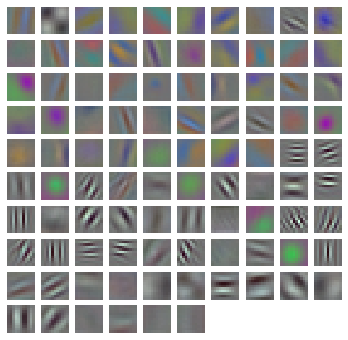

In [20]:
mlutils.display_imgs(w[0])

In [21]:
model.save("alexnet_finetuned_minicifar.model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: alexnet_finetuned_minicifar.model/assets


observe that you can also save separately the architecture

In [0]:
with open('alexnet_finetuned_minicifar.architecture.json', 'w') as f:
    f.write(model.to_json())

In [58]:
!ls -lash alexnet_finetuned_minicifar*

4.0K -rw-r--r-- 1 root root 3.5K Feb 29 01:17 alexnet_finetuned_minicifar.architecture.json

alexnet_finetuned_minicifar.model:
total 168K
4.0K drwxr-xr-x 4 root root 4.0K Feb 29 01:16 .
4.0K drwxr-xr-x 1 root root 4.0K Feb 29 00:55 ..
4.0K drwxr-xr-x 2 root root 4.0K Feb 29 00:55 assets
152K -rw-r--r-- 1 root root 151K Feb 29 01:16 saved_model.pb
4.0K drwxr-xr-x 2 root root 4.0K Feb 29 01:16 variables


In [59]:
!head alexnet_finetuned_minicifar.architecture.json

{"class_name": "Model", "config": {"name": "model_3", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 32, 32, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Conv2D", "config": {"name": "conv2d_6", "trainable": true, "dtype": "float32", "filters": 96, "kernel_size": [11, 11], "strides": [1, 1], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "name": "conv2d_6", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "MaxPooling2D", "config": {"name": "max_pooling2d_3", "trainable": true, "dtype": "float32", "pool_size": [2, 2]

## let's zip the model so you can send and share it

In [22]:
!zip -r alexnet_finetuned_minicifar.model.zip alexnet_finetuned_minicifar.model

  adding: alexnet_finetuned_minicifar.model/ (stored 0%)
  adding: alexnet_finetuned_minicifar.model/variables/ (stored 0%)
  adding: alexnet_finetuned_minicifar.model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: alexnet_finetuned_minicifar.model/variables/variables.index (deflated 64%)
  adding: alexnet_finetuned_minicifar.model/assets/ (stored 0%)
  adding: alexnet_finetuned_minicifar.model/saved_model.pb (deflated 89%)
